# 🧠 Workshop: Build a Coding LLM from Scratch
## Part IV: Post-Training (Supervised Fine-Tuning)
### 🎯 Focus: Teaching the Model to Follow Instructions with Reasoning

**Auteur :** Équipe IRA

**Date :** 1 Décembre 2025

**Contexte :** Ce notebook démontre le **Post-Training** d'un modèle pré-entraîné pour qu'il suive des instructions et génère du code avec raisonnement. Nous utilisons un dataset structuré instruction→reasoning→code pour apprendre au modèle à comprendre les consignes et à raisonner avant de coder.

---

## 📋 Table des matières

1. **Introduction théorique** : Qu'est-ce que le Post-Training ?
2. **Récupération des artefacts du Pre-Training**
3. **Chargement et exploration du dataset SFT**
4. **Préparation et encodage des données**
5. **Chargement du modèle pré-entraîné**
6. **Boucle de Post-Training (SFT)**
7. **Évaluation et tests**
8. **Sauvegarde finale**
9. **Comparaison Pre-Training vs Post-Training**

---

## 🔹 Partie 1 : Introduction Théorique

### Qu'est-ce que le Post-Training ?

Le **Post-Training** (ou **Supervised Fine-Tuning - SFT**) est la phase où un modèle pré-entraîné apprend à suivre des instructions spécifiques.

### Différence Pre-Training vs Post-Training

| Aspect | Pre-Training | Post-Training (SFT) |
|--------|--------------|---------------------|
| **Données** | Code brut (non structuré) | Paires instruction→code structurées |
| **Objectif** | Apprendre la syntaxe Python | Suivre des consignes précises |
| **Format** | Texte continu | Format question-réponse |
| **Exemple entrée** | `def fibonacci(n):...` | `"Écris une fonction fibonacci"` |
| **Exemple sortie** | Token suivant | Fonction complète avec raisonnement |

### Notre Dataset SFT

Format : **Instruction → Reasoning → Code**

```json
{
  "instruction": "Return sum of even numbers up to n",
  "reasoning": "Iterate and sum numbers divisible by 2",
  "answer": "def sum_even_1_to_n(n):\n    return sum(i for i in range(2, n+1, 2))"
}
```

**Avantages** :
- ✅ Le modèle apprend à **comprendre les consignes**
- ✅ Le modèle apprend à **raisonner** avant de coder
- ✅ Le code généré est **aligné** avec les besoins humains

### Pipeline Post-Training

```
Modèle Pré-entraîné → SFT Dataset → Fine-Tuning → Modèle Instruit
```

---

## 🔹 Partie 2 : Récupération des Artefacts du Pre-Training

Nous récupérons le modèle et le tokenizer créés dans le notebook **Pre-Training**.

### Fichiers nécessaires :
- ✅ `models/pre_training/mini_gpt_code_FINAL.pt` - Modèle pré-entraîné
- ✅ `models/pre_training/tokenizer/` - Tokenizer GPT-2
- ✅ Architecture `MiniGPT` (définie dans le notebook précédent)

In [1]:
# %% Cell 1: Imports et Configuration

# ============================================================================
# IMPORTS DES BIBLIOTHÈQUES NÉCESSAIRES
# ============================================================================

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import GPT2Tokenizer

# ============================================================================
# CONFIGURATION POUR LA REPRODUCTIBILITÉ
# ============================================================================
torch.manual_seed(42)
np.random.seed(42)

# ============================================================================
# DÉTECTION DU DEVICE
# ============================================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Device utilisé : {device}")
print(f"🔥 PyTorch version : {torch.__version__}")

# ============================================================================
# HYPERPARAMÈTRES DU POST-TRAINING
# ============================================================================

# Vérifier que les fichiers du pre-training existent
required_files = [
    "models/pre_training/mini_gpt_code_FINAL.pt",
    "models/pre_training/tokenizer/tokenizer_config.json"
]

print("\n📂 Vérification des fichiers du Pre-Training...")
all_exist = True
for file in required_files:
    exists = os.path.exists(file)
    status = "✅" if exists else "❌"
    print(f"   {status} {file}")
    if not exists:
        all_exist = False

if not all_exist:
    print("\n⚠️  ATTENTION : Certains fichiers du Pre-Training sont manquants!")
    print("   Veuillez d'abord exécuter le notebook 'notebook.ipynb' (Pre-Training)")
else:
    print("\n✅ Tous les fichiers nécessaires sont présents!")

# Hyperparamètres spécifiques au Post-Training
BATCH_SIZE = 8           # Plus petit batch pour SFT (données plus riches)
N_EPOCHS = 5             # Plus d'époques pour bien apprendre les instructions
LEARNING_RATE = 1e-4     # Learning rate plus faible (fine-tuning)
MAX_LENGTH = 256         # Longueur max des séquences

🚀 Device utilisé : cuda
🔥 PyTorch version : 2.3.1

📂 Vérification des fichiers du Pre-Training...
   ❌ models/pre_training/mini_gpt_code_FINAL.pt
   ✅ models/pre_training/tokenizer/tokenizer_config.json

⚠️  ATTENTION : Certains fichiers du Pre-Training sont manquants!
   Veuillez d'abord exécuter le notebook 'notebook.ipynb' (Pre-Training)


## 🔹 Partie 3 : Chargement et Exploration du Dataset SFT

Notre dataset contient **10,000 exemples** de code Python avec instructions et raisonnement.

### Structure des données :
- **instruction** : Ce que l'utilisateur demande
- **reasoning** : Le raisonnement pour résoudre le problème
- **answer** : Le code Python correspondant

In [2]:
# %% Cell 2: Chargement du Dataset SFT

print("📥 Chargement du dataset SFT (data/python_reasoning_dataset.jsonl)...")

# ============================================================================
# CHARGEMENT DU FICHIER JSONL
# ============================================================================
# Chaque ligne est un objet JSON
sft_data = []
dataset_path = "data/python_reasoning_dataset.jsonl"

with open(dataset_path, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f, start=1):
        line = line.strip()

        # Ignorer les lignes vides
        if not line:
            print(f"⚠️ Ligne vide ignorée (ligne {idx})")
            continue

        try:
            example = json.loads(line)
            sft_data.append(example)
        except json.JSONDecodeError as e:
            print(f"❌ Ligne JSON invalide à la ligne {idx}: {e}")
            print("   ➤ Contenu :", line[:200])
            continue

print(f"\n✅ Dataset chargé : {len(sft_data):,} exemples valides\n")

# ============================================================================
# EXPLORATION DU DATASET
# ============================================================================
print("\n📊 Statistiques du dataset :")

# Compter les longueurs
instruction_lengths = [len(ex['instruction']) for ex in sft_data]
reasoning_lengths = [len(ex['reasoning']) for ex in sft_data]
answer_lengths = [len(ex['answer']) for ex in sft_data]

print(f"   - Instruction moyenne : {np.mean(instruction_lengths):.1f} caractères")
print(f"   - Reasoning moyen     : {np.mean(reasoning_lengths):.1f} caractères")
print(f"   - Answer moyen        : {np.mean(answer_lengths):.1f} caractères")

# Afficher quelques exemples
print("\n--- 📋 Exemples du dataset ---\n")
for i in range(3):
    ex = sft_data[i]
    print(f"Exemple {i+1}:")
    print(f"  Instruction: {ex['instruction']}")
    print(f"  Reasoning:   {ex['reasoning']}")
    print(f"  Answer:      {ex['answer'][:100]}...")  # Tronquer pour affichage
    print()

📥 Chargement du dataset SFT (data/python_reasoning_dataset.jsonl)...
⚠️ Ligne vide ignorée (ligne 10380)
⚠️ Ligne vide ignorée (ligne 10381)
⚠️ Ligne vide ignorée (ligne 10382)

✅ Dataset chargé : 10,379 exemples valides


📊 Statistiques du dataset :
   - Instruction moyenne : 34.3 caractères
   - Reasoning moyen     : 33.0 caractères
   - Answer moyen        : 80.5 caractères

--- 📋 Exemples du dataset ---

Exemple 1:
  Instruction: Return sum of even numbers up to n
  Reasoning:   Iterate and sum numbers divisible by 2
  Answer:      def sum_even_1_to_n(n):\n    return sum(i for i in range(2, n+1, 2))...

Exemple 2:
  Instruction: Return all prime numbers up to n
  Reasoning:   Check each number for primality
  Answer:      def primes_up_to(n):\n    def is_prime(x):\n        if x<2: return False\n        for i in range(2,i...

Exemple 3:
  Instruction: Return all prime numbers up to n
  Reasoning:   Check each number for primality
  Answer:      def primes_up_to(n):\n    def is_prime

## 🔹 Partie 4 : Préparation et Encodage des Données

### Format d'entraînement

Nous créons un format structuré pour que le modèle apprenne :
```
<instruction> {instruction} <reasoning> {reasoning} <answer> {answer}
```

Ce format permet au modèle de distinguer les différentes parties.

In [3]:
# %% Cell 3: Chargement du Tokenizer
from transformers import AutoTokenizer

print("🔤 Chargement du tokenizer pré-entraîné...")

# ============================================================================
# CHARGER LE TOKENIZER SAUVEGARDÉ
# ============================================================================
# Utiliser le même tokenizer que le Pre-Training

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
tokenizer.pad_token = tokenizer.eos_token

vocab_size = tokenizer.vocab_size
print(f"✅ Tokenizer chargé (vocabulaire : {vocab_size:,} tokens)")

# ============================================================================
# AJOUTER DES TOKENS SPÉCIAUX POUR LE SFT
# ============================================================================
# Tokens spéciaux pour structurer le format instruction-reasoning-answer
special_tokens = {
    'additional_special_tokens': ['<instruction>', '<reasoning>', '<answer>']
}

num_added = tokenizer.add_special_tokens(special_tokens)
print(f"✅ {num_added} tokens spéciaux ajoutés")
print(f"📚 Nouvelle taille du vocabulaire : {len(tokenizer):,}")

# Afficher les IDs des nouveaux tokens
print("\n🔖 Tokens spéciaux :")
print(f"   <instruction> → ID {tokenizer.encode('<instruction>', add_special_tokens=False)[0]}")
print(f"   <reasoning>   → ID {tokenizer.encode('<reasoning>', add_special_tokens=False)[0]}")
print(f"   <answer>      → ID {tokenizer.encode('<answer>', add_special_tokens=False)[0]}")

🔤 Chargement du tokenizer pré-entraîné...
✅ Tokenizer chargé (vocabulaire : 50,254 tokens)
✅ 3 tokens spéciaux ajoutés
📚 Nouvelle taille du vocabulaire : 50,280

🔖 Tokens spéciaux :
   <instruction> → ID 50277
   <reasoning>   → ID 50278
   <answer>      → ID 50279


In [4]:
# %% Cell 4: Création du Dataset PyTorch pour SFT

# ============================================================================
# CLASSE DATASET POUR POST-TRAINING
# ============================================================================

class SFTDataset(Dataset):
    """
    Dataset pour Supervised Fine-Tuning
    Encode les exemples au format: <instruction> ... <reasoning> ... <answer> ...
    """
    
    def __init__(self, data, tokenizer, max_length=256):
        """
        Args:
            data (list): Liste de dictionnaires {instruction, reasoning, answer}
            tokenizer: Tokenizer GPT-2
            max_length (int): Longueur maximale des séquences
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Retourne une séquence encodée pour l'entraînement
        """
        example = self.data[idx]
        
        # ====================================================================
        # FORMAT: <instruction> X <reasoning> Y <answer> Z
        # ====================================================================
        text = (
            f"<instruction> {example['instruction']} "
            f"<reasoning> {example['reasoning']} "
            f"<answer> {example['answer']}"
        )
        
        # Encoder le texte complet
        encoded = self.tokenizer.encode(text, add_special_tokens=False)
        
        # Tronquer ou padder à max_length
        if len(encoded) > self.max_length:
            encoded = encoded[:self.max_length]
        else:
            # Padding avec eos_token
            encoded = encoded + [self.tokenizer.eos_token_id] * (self.max_length - len(encoded))
        
        # Créer input et target (décalé de 1 pour CLM)
        input_ids = torch.tensor(encoded[:-1], dtype=torch.long)   # Tous sauf le dernier
        target_ids = torch.tensor(encoded[1:], dtype=torch.long)   # Tous sauf le premier
        
        return input_ids, target_ids

# ============================================================================
# CRÉER LES DATASETS TRAIN/VAL
# ============================================================================
print("📂 Création des datasets SFT...")

# Split 90/10
split_idx = int(0.9 * len(sft_data))
train_data = sft_data[:split_idx]
val_data = sft_data[split_idx:]

print(f"   - Train : {len(train_data):,} exemples")
print(f"   - Val   : {len(val_data):,} exemples")

# Créer les datasets
train_dataset = SFTDataset(train_data, tokenizer, MAX_LENGTH)
val_dataset = SFTDataset(val_data, tokenizer, MAX_LENGTH)

# Créer les DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    drop_last=True
)

print(f"\n✅ Datasets créés")
print(f"📦 Train batches : {len(train_loader)}")
print(f"📦 Val batches   : {len(val_loader)}")

# ============================================================================
# TEST D'ENCODAGE
# ============================================================================
print("\n--- 🧪 Test d'encodage ---")
test_input, test_target = train_dataset[0]
print(f"Shape input  : {test_input.shape}")
print(f"Shape target : {test_target.shape}")
print(f"\nDécodage de l'input :")
print(tokenizer.decode(test_input.tolist())[:200] + "...")

📂 Création des datasets SFT...
   - Train : 9,341 exemples
   - Val   : 1,038 exemples

✅ Datasets créés
📦 Train batches : 1167
📦 Val batches   : 129

--- 🧪 Test d'encodage ---
Shape input  : torch.Size([255])
Shape target : torch.Size([255])

Décodage de l'input :
<instruction> Return sum of even numbers up to n <reasoning> Iterate and sum numbers divisible by 2 <answer> def sum_even_1_to_n(n):\n    return sum(i for i in range(2, n+1, 2))<|endoftext|><|endoftex...


## 🔹 Partie 5 : Chargement du Modèle Pré-Entraîné

Nous chargeons le **MiniGPT pré-entraîné** depuis le checkpoint sauvegardé.

⚠️ **Important** : Nous devons **redéfinir l'architecture** car elle n'est pas sauvegardée dans le checkpoint.

In [ ]:
# %% Cell 5: Redéfinition de l'Architecture MiniGPT

from dataclasses import dataclass
import math
# ============================================================================
# COPIE DE L'ARCHITECTURE DU PRE-TRAINING
# ============================================================================
# On doit redéfinir toutes les classes car elles ne sont pas dans le checkpoint

class CausalSelfAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, block_size):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.qkv = torch.nn.Linear(d_model, 3 * d_model)
        self.proj = torch.nn.Linear(d_model, d_model)

        mask = torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.proj(y)

class Block(torch.nn.Module):
    def __init__(self, d_model, n_heads, d_ff, block_size):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, block_size)
        self.ln2 = torch.nn.LayerNorm(d_model)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_ff),
            torch.nn.GELU(),
            torch.nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x


class TinyDecoderLM(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        # ✅ Embeddings
        self.tok_emb = torch.nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = torch.nn.Embedding(cfg.block_size, cfg.d_model)
        # ✅ Transformer blocks (8 blocks)
        self.blocks = torch.nn.ModuleList([
            Block(cfg.d_model, cfg.n_heads, cfg.d_ff, cfg.block_size)
            for _ in range(cfg.n_layers)
        ])
        # ✅ Final layer norm and head
        self.ln_f = torch.nn.LayerNorm(cfg.d_model)
        self.head = torch.nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        """
        Forward pass avec support optionnel du calcul de loss
        
        Args:
            idx: input token ids (B, T)
            targets: target token ids pour CLM (B, T) - optionnel
            
        Returns:
            logits: (B, T, vocab_size)
            loss: scalar tensor si targets est fourni, sinon None
        """
        B, T = idx.shape
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        x = self.tok_emb(idx) + self.pos_emb(pos)
        
        for blk in self.blocks:
            x = blk(x)
        
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)
        
        # Calculer la loss si targets est fourni
        loss = None
        if targets is not None:
            # Reshape pour cross_entropy
            loss = F.cross_entropy(
                logits.view(-1, self.cfg.vocab_size),
                targets.view(-1),
                ignore_index=-100
            )
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Génération de tokens de manière autoregressive
        
        Args:
            idx: (B, T) initial token ids
            max_new_tokens: nombre de tokens à générer
            temperature: contrôle la randomness (> 1 = plus random)
            top_k: si fourni, sample parmi les top_k tokens
            
        Returns:
            idx: (B, T + max_new_tokens) tokens générés
        """
        for _ in range(max_new_tokens):
            # Limiter à block_size
            idx_cond = idx[:, -self.cfg.block_size:]
            
            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # (B, vocab_size)
            
            # Top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            
            # Softmax et sampling
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx


# ============================================================
# 2. MODEL CONFIG
# ============================================================

@dataclass
class ModelConfig:
    vocab_size: int = 50257
    d_model: int = 512
    n_heads: int = 8
    n_layers: int = 8
    d_ff: int = 2048
    block_size: int = 256

    

print("✅ Architecture redéfinie")

✅ Architecture redéfinie


In [6]:
# %% Cell 6: Chargement du Modèle Pré-Entraîné

print("📥 Chargement du modèle pré-entraîné...")

# ============================================================================
# CHARGER LE CHECKPOINT
# ============================================================================
checkpoint = torch.load("models/pre_training/model_final.pt", map_location=device)

# Récupérer la configuration
pretrained_state = checkpoint
config = ModelConfig()
print(f"\n📊 Configuration du modèle :")
print(f"   - Vocabulaire   : {config.vocab_size:,}")
print(f"   - Block size    : {config.block_size}")
print(f"   - d_model       : {config.d_model}")
print(f"   - Attention heads: {config.n_heads}")
print(f"   - Layers        : {config.n_layers}")
print(f"   - d_ff          : {config.d_ff}")

# ============================================================================
# INSTANCIER LE MODÈLE AVEC LA NOUVELLE TAILLE DE VOCABULAIRE
# ============================================================================
# IMPORTANT: Le vocabulaire a augmenté avec les tokens spéciaux !
new_vocab_size = len(tokenizer)

print(f"\n🔧 Ajustement du vocabulaire :")
print(f"   - Ancien vocabulaire : {config.vocab_size:,}")
print(f"   - Nouveau vocabulaire: {new_vocab_size:,}")
print(f"   - Tokens ajoutés     : {new_vocab_size - config.vocab_size:,}")

# Créer le modèle avec le NOUVEAU vocabulaire
config.vocab_size = new_vocab_size
model = TinyDecoderLM(config).to(device)

# ============================================================================
# CHARGER LES POIDS PRÉ-ENTRAÎNÉS
# ============================================================================
# Les embeddings ont une taille différente, on doit les ajuster
print(f"Clés du checkpoint: {list(pretrained_state.keys())[:5]}...")

# Récupérer les anciens embeddings
old_token_emb = pretrained_state['tok_emb.weight']
old_vocab_size, emb_dim = old_token_emb.shape

# Créer de nouveaux embeddings (avec les tokens spéciaux)
new_token_emb = model.tok_emb.weight.data.clone()

# Copier les anciens poids
new_token_emb[:old_vocab_size] = old_token_emb

# Mettre à jour le state_dict
pretrained_state['tok_emb.weight'] = new_token_emb
pretrained_state['head.weight'] = new_token_emb  # Weight tying

# Charger les poids
model.load_state_dict(pretrained_state, strict=False)

print(f"\n✅ Modèle chargé avec {sum(p.numel() for p in model.parameters()):,} paramètres")
print(f"📈 Validation loss du pre-training : {checkpoint.get('best_val_loss', 'N/A')}")

# Mettre en mode entraînement
model.train()

📥 Chargement du modèle pré-entraîné...

📊 Configuration du modèle :
   - Vocabulaire   : 50,257
   - Block size    : 256
   - d_model       : 512
   - Attention heads: 8
   - Layers        : 8
   - d_ff          : 2048

🔧 Ajustement du vocabulaire :
   - Ancien vocabulaire : 50,257
   - Nouveau vocabulaire: 50,280
   - Tokens ajoutés     : 23
Clés du checkpoint: ['tok_emb.weight', 'pos_emb.weight', 'blocks.0.ln1.weight', 'blocks.0.ln1.bias', 'blocks.0.attn.mask']...

✅ Modèle chargé avec 76,837,888 paramètres
📈 Validation loss du pre-training : N/A


TinyDecoderLM(
  (tok_emb): Embedding(50280, 512)
  (pos_emb): Embedding(256, 512)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=512, out_features=50280, bias=False)
)

## 🔹 Partie 6 : Boucle de Post-Training (SFT)

Nous fine-tunons le modèle sur les données d'instructions.

### Stratégie d'entraînement :
- Learning rate plus faible (1e-4 vs 3e-4 en pre-training)
- Plus d'époques (5 vs 3)
- Monitoring de la qualité des réponses

In [7]:
# %% Cell 7: Configuration de l'Optimisation

# ============================================================================
# OPTIMIZER ET SCHEDULER
# ============================================================================
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,  # 1e-4 (plus faible que pre-training)
    weight_decay=0.01
)

from torch.optim.lr_scheduler import CosineAnnealingLR
total_steps = len(train_loader) * N_EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

# ============================================================================
# FONCTION D'ÉVALUATION
# ============================================================================
@torch.no_grad()
def evaluate(model, val_loader, max_batches=50):
    """Calcule la loss moyenne sur la validation"""
    model.eval()
    total_loss = 0
    count = 0
    
    for batch_idx, (x, y) in enumerate(val_loader):
        if batch_idx >= max_batches:
            break
        
        x, y = x.to(device), y.to(device)
        _, loss = model(x, y)
        total_loss += loss.item()
        count += 1
    
    model.train()
    return total_loss / count if count > 0 else 0

# ============================================================================
# HISTORIQUE DES MÉTRIQUES
# ============================================================================
history = {
    'train_loss': [],
    'val_loss': [],
    'epochs': []
}

print("✅ Configuration de l'optimisation terminée")
print(f"📊 Total steps : {total_steps:,}")

✅ Configuration de l'optimisation terminée
📊 Total steps : 5,835


In [10]:
# %% Cell 8: Boucle de Post-Training

print("🚀 Début du Post-Training (SFT)...")
print(f"📊 Configuration: {N_EPOCHS} époques, {len(train_loader)} batches/époque\n")

# ============================================================================
# BOUCLE D'ENTRAÎNEMENT
# ============================================================================
model.train()
global_step = 0

for epoch in range(N_EPOCHS):
    print(f"\n{'='*60}")
    print(f"📅 Époque {epoch+1}/{N_EPOCHS}")
    print(f"{'='*60}")
    
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"SFT Epoch {epoch+1}")
    
    for batch_idx, (x, y) in enumerate(pbar):
        # Déplacer sur device
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        logits, loss = model(x, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        scheduler.step()
        
        # Logging
        epoch_loss += loss.item()
        global_step += 1
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{epoch_loss/(batch_idx+1):.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })
    
    # Métriques de fin d'époque
    avg_train_loss = epoch_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['epochs'].append(epoch + 1)
    
    print(f"\n📊 Fin Époque {epoch+1}:")
    print(f"   - Train Loss: {avg_train_loss:.4f}")
    print(f"   - Val Loss:   {val_loss:.4f}")
    print(f"   - Perplexity: {np.exp(val_loss):.2f}")
    
    # Test de génération
    print(f"\n🎯 Test de génération (epoch {epoch+1}):")
    test_prompt = "<instruction> Write a function to calculate factorial <reasoning>"
    test_ids = torch.tensor([tokenizer.encode(test_prompt)], device=device)
    generated = model.generate(test_ids, max_new_tokens=100, temperature=0.7, top_k=50)
    print(tokenizer.decode(generated[0].tolist()))
    print()
    
    # Sauvegarde du checkpoint
    os.makedirs("checkpoints_sft", exist_ok=True)
    checkpoint_sft = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history,
        'config': {
            'vocab_size': new_vocab_size,
            'block_size': config.block_size,
            'd_model': config.d_model,
            'n_head': config.n_heads,
            'n_layer': config.n_layers,
            'd_ff': config.d_ff
        }
    }
    checkpoint_path = f"models/post_training/model_sft_epoch_{epoch+1}.pt"
    torch.save(checkpoint_sft, checkpoint_path)
    print(f"💾 Checkpoint SFT sauvegardé : {checkpoint_path}")

print("\n✅ Post-Training terminé !")
print(f"📁 {N_EPOCHS} checkpoints SFT sauvegardés dans models/post_training/")

🚀 Début du Post-Training (SFT)...
📊 Configuration: 5 époques, 1167 batches/époque


📅 Époque 1/5


SFT Epoch 1:   0%|          | 0/1167 [00:00<?, ?it/s]


📊 Fin Époque 1:
   - Train Loss: 0.0137
   - Val Loss:   0.0121
   - Perplexity: 1.01

🎯 Test de génération (epoch 1):
<instruction> Write a function to calculate factorial <reasoning> Check each number for primality <answer> def primes_n):\n    def(n    def is_prime(x):\n        if x<2: return False\n        for i in range(2,int(x**0.5)+1):\n            if x%i==0: return False\n        return True\n    return [i for i in range(2,n+1) if is_prime(i)]<|endoftext|><|endoftext|>

💾 Checkpoint SFT sauvegardé : models/post_training/model_sft_epoch_1.pt

📅 Époque 2/5


SFT Epoch 2:   0%|          | 0/1167 [00:00<?, ?it/s]


📊 Fin Époque 2:
   - Train Loss: 0.0117
   - Val Loss:   0.0116
   - Perplexity: 1.01

🎯 Test de génération (epoch 2):
<instruction> Write a function to calculate factorial <reasoning> Use max function <answer> def largest(lst):\n    return max(lst)<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

SFT Epoch 3:   0%|          | 0/1167 [00:00<?, ?it/s]


📊 Fin Époque 3:
   - Train Loss: 0.0115
   - Val Loss:   0.0115
   - Perplexity: 1.01

🎯 Test de génération (epoch 3):
<instruction> Write a function to calculate factorial <reasoning> Check if n <answer> def is_s(n):\n    return s[::-1]<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

SFT Epoch 4:   0%|          | 0/1167 [00:00<?, ?it/s]


📊 Fin Époque 4:
   - Train Loss: 0.0115
   - Val Loss:   0.0115
   - Perplexity: 1.01

🎯 Test de génération (epoch 4):
<instruction> Write a function to calculate factorial <reasoning> Check each number for primality <answer> def primes_up_to(n):\n    def is_prime(x):\n        if x<2: return False\n        for i in range(2,int(x**0.5)+1):\n            if x%i==0: return False\n        return True\n    return [i for i in range(2,n+1) if is_prime(i)]<|endoftext|><|endoftext|>

💾 Checkpoint SFT sauvegardé : models/post_training/model_sft_epoch_4.pt

📅 Époque 5/5


SFT Epoch 5:   0%|          | 0/1167 [00:00<?, ?it/s]


📊 Fin Époque 5:
   - Train Loss: 0.0117
   - Val Loss:   0.0117
   - Perplexity: 1.01

🎯 Test de génération (epoch 5):
<instruction> Write a function to calculate factorial <reasoning> Check if n <answer> def is_(n):\n    return(lst)<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

## 🔹 Partie 7 : Visualisation des Résultats

C:\Users\amine\AppData\Local\Temp\ipykernel_28152\647608299.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\amine\AppData\Local\Temp\ipykernel_28152\647608299.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\amine\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amine\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


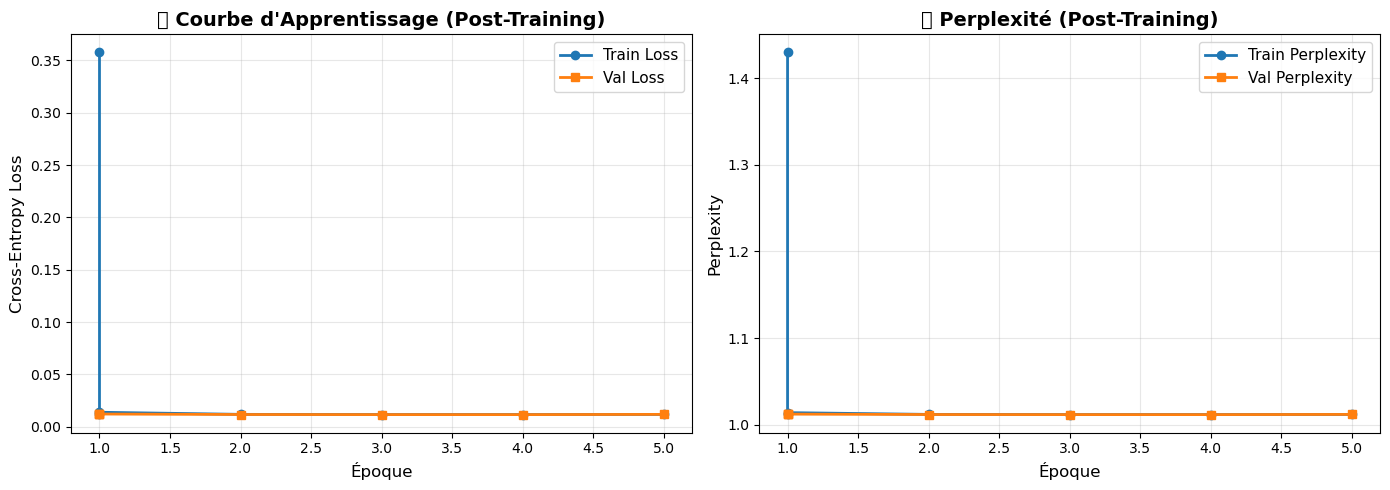


📈 Analyse des résultats Post-Training:
   - Amélioration train: 0.3460
   - Amélioration val:   0.0008
   - Gap train/val:      0.0000


In [11]:
# %% Cell 9: Visualisation de la Loss

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe de loss
axes[0].plot(history['epochs'], history['train_loss'], marker='o', label='Train Loss', linewidth=2)
axes[0].plot(history['epochs'], history['val_loss'], marker='s', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Époque', fontsize=12)
axes[0].set_ylabel('Cross-Entropy Loss', fontsize=12)
axes[0].set_title('📉 Courbe d\'Apprentissage (Post-Training)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Perplexity
perplexity_train = [np.exp(loss) for loss in history['train_loss']]
perplexity_val = [np.exp(loss) for loss in history['val_loss']]
axes[1].plot(history['epochs'], perplexity_train, marker='o', label='Train Perplexity', linewidth=2)
axes[1].plot(history['epochs'], perplexity_val, marker='s', label='Val Perplexity', linewidth=2)
axes[1].set_xlabel('Époque', fontsize=12)
axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('📊 Perplexité (Post-Training)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse
print("\n📈 Analyse des résultats Post-Training:")
improvement_train = history['train_loss'][0] - history['train_loss'][-1]
improvement_val = history['val_loss'][0] - history['val_loss'][-1]
print(f"   - Amélioration train: {improvement_train:.4f}")
print(f"   - Amélioration val:   {improvement_val:.4f}")
print(f"   - Gap train/val:      {history['val_loss'][-1] - history['train_loss'][-1]:.4f}")

## 🔹 Partie 8 : Tests de Génération avec Instructions

In [12]:
# %% Cell 10: Tests de Génération

def generate_from_instruction(instruction, max_tokens=150, temperature=0.7, top_k=40):
    """Génère du code à partir d'une instruction"""
    model.eval()
    prompt = f"<instruction> {instruction} <reasoning>"
    input_ids = torch.tensor([tokenizer.encode(prompt)], device=device)
    
    with torch.no_grad():
        output_ids = model.generate(
            input_ids, 
            max_new_tokens=max_tokens, 
            temperature=temperature, 
            top_k=top_k
        )
    
    generated = tokenizer.decode(output_ids[0].tolist())
    model.train()
    return generated

# Tests
test_instructions = [
    "Write a function to check if a number is prime",
    "Create a function to reverse a list",
    "Implement binary search algorithm",
    "Write a function to calculate Fibonacci sequence",
]

print("🎯 TESTS DE GÉNÉRATION AVEC INSTRUCTIONS\n")
print("="*70)

for i, instruction in enumerate(test_instructions, 1):
    print(f"\n{'='*70}")
    print(f"Test {i}: {instruction}")
    print(f"{'='*70}\n")
    result = generate_from_instruction(instruction, max_tokens=200, temperature=0.7)
    print(result)
    print()

print("\n" + "="*70)
print("✅ Tests de génération terminés")

🎯 TESTS DE GÉNÉRATION AVEC INSTRUCTIONS


Test 1: Write a function to check if a number is prime

<instruction> Write a function to check if a number is prime <reasoning> Check if 5 <answer> def is_odd(n):\n    return n % 2 == 1<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end

## 🔹 Partie 9 : Sauvegarde Finale du Modèle Post-Entraîné

In [14]:
# %% Cell 11: Sauvegarde Finale

print("="*70)
print("💾 SAUVEGARDE FINALE DU MODÈLE POST-ENTRAÎNÉ")
print("="*70)

# Analyser les checkpoints SFT
print("\n📊 Analyse des checkpoints SFT...")
best_epoch = 0
best_val_loss = float('inf')

for epoch in range(1, N_EPOCHS + 1):
    checkpoint_path = f"models/post_training/model_sft_epoch_{epoch}.pt"
    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path)
        val_loss = ckpt['history']['val_loss'][-1]
        print(f"   Époque {epoch}: Val Loss = {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch

print(f"\n🏆 Meilleur modèle SFT : Époque {best_epoch} (Val Loss = {best_val_loss:.4f})")

# Charger le meilleur checkpoint
best_checkpoint_path = f"models/post_training/model_sft_epoch_{best_epoch}.pt"
best_checkpoint = torch.load(best_checkpoint_path)

# Sauvegarder le modèle final
final_model_path = "models/post_training/model_sft_FINAL.pt"
torch.save({
    'epoch': best_checkpoint['epoch'],
    'model_state_dict': best_checkpoint['model_state_dict'],
    'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
    'scheduler_state_dict': best_checkpoint['scheduler_state_dict'],
    'history': best_checkpoint['history'],
    'config': best_checkpoint['config'],
    'best_val_loss': best_val_loss,
    'selected_from_epoch': best_epoch,
    'training_stage': 'post-training'
}, final_model_path)

print(f"💾 Modèle final SFT sauvegardé : {final_model_path}")

# Sauvegarder les poids seuls
model_weights_path = "models/post_training/model_weights_only.pt"
torch.save(best_checkpoint['model_state_dict'], model_weights_path)
print(f"⚡ Poids seuls sauvegardés : {model_weights_path}")

# Sauvegarder le tokenizer mis à jour
tokenizer.save_pretrained("models/post_training/tokenizer")
print(f"🔤 Tokenizer mis à jour sauvegardé : models/post_training/tokenizer/")

print("\n" + "="*70)
print("📦 RÉSUMÉ DES ARTEFACTS CRÉÉS")
print("="*70)
print(f"✅ Checkpoints SFT : models/post_training/model_sft_epoch_[1-{N_EPOCHS}].pt")
print(f"✅ Modèle final SFT: {final_model_path}")
print(f"✅ Poids seuls     : {model_weights_path}")
print(f"✅ Tokenizer SFT   : models/post_training/tokenizer/")

print("\n" + "="*70)
print("📌 UTILISATION DU MODÈLE POST-ENTRAÎNÉ")
print("="*70)
print("\n# Charger le modèle SFT")
print("checkpoint = torch.load('models/post_training/model_sft_FINAL.pt')")
print("model.load_state_dict(checkpoint['model_state_dict'])")
print("tokenizer = AutoTokenizer.from_pretrained('models/post_training/tokenizer')")

💾 SAUVEGARDE FINALE DU MODÈLE POST-ENTRAÎNÉ

📊 Analyse des checkpoints SFT...
   Époque 1: Val Loss = 0.0121
   Époque 2: Val Loss = 0.0116
   Époque 3: Val Loss = 0.0115
   Époque 4: Val Loss = 0.0115
   Époque 5: Val Loss = 0.0117

🏆 Meilleur modèle SFT : Époque 4 (Val Loss = 0.0115)
💾 Modèle final SFT sauvegardé : models/post_training/model_sft_FINAL.pt
⚡ Poids seuls sauvegardés : models/post_training/model_weights_only.pt
🔤 Tokenizer mis à jour sauvegardé : models/post_training/tokenizer/

📦 RÉSUMÉ DES ARTEFACTS CRÉÉS
✅ Checkpoints SFT : models/post_training/model_sft_epoch_[1-5].pt
✅ Modèle final SFT: models/post_training/model_sft_FINAL.pt
✅ Poids seuls     : models/post_training/model_weights_only.pt
✅ Tokenizer SFT   : models/post_training/tokenizer/

📌 UTILISATION DU MODÈLE POST-ENTRAÎNÉ

# Charger le modèle SFT
checkpoint = torch.load('models/post_training/model_sft_FINAL.pt')
model.load_state_dict(checkpoint['model_state_dict'])
tokenizer = AutoTokenizer.from_pretrained('mod

## 🔹 Partie 10 : Comparaison Pre-Training vs Post-Training

In [18]:
# %% Cell 12: Comparaison des Modèles

print("📊 COMPARAISON PRE-TRAINING vs POST-TRAINING")
print("="*70)

# Charger les métriques du pre-training
pretrain_checkpoint = torch.load("models/pre_training/model_final.pt")
print(list(checkpoint.keys()))
pretrain_val_loss = pretrain_checkpoint.get('val_loss', None)

print(f"\n📈 Métriques finales :")
print(f"\nPre-Training (Base Model):")
print(f"   - Validation Loss : {pretrain_val_loss}")
print(f"   - Objectif        : Apprendre la syntaxe Python")
print(f"   - Dataset         : Code brut (100k documents)")

print(f"\nPost-Training (SFT Model):")
print(f"   - Validation Loss : {best_val_loss:.4f}")
print(f"   - Objectif        : Suivre des instructions")
print(f"   - Dataset         : Paires instruction-code (10k exemples)")

print(f"\n🎯 Amélioration :")
if isinstance(pretrain_val_loss, float):
    improvement = pretrain_val_loss - best_val_loss
    print(f"   - Réduction de loss : {improvement:.4f} ({improvement/pretrain_val_loss*100:.1f}%)")

print("\n" + "="*70)
print("✅ Post-Training terminé avec succès !")
print("🎉 Le modèle peut maintenant suivre des instructions et générer du code structuré !")

📊 COMPARAISON PRE-TRAINING vs POST-TRAINING
['tok_emb.weight', 'pos_emb.weight', 'blocks.0.ln1.weight', 'blocks.0.ln1.bias', 'blocks.0.attn.mask', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.ln2.weight', 'blocks.0.ln2.bias', 'blocks.0.ff.0.weight', 'blocks.0.ff.0.bias', 'blocks.0.ff.2.weight', 'blocks.0.ff.2.bias', 'blocks.1.ln1.weight', 'blocks.1.ln1.bias', 'blocks.1.attn.mask', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.ln2.weight', 'blocks.1.ln2.bias', 'blocks.1.ff.0.weight', 'blocks.1.ff.0.bias', 'blocks.1.ff.2.weight', 'blocks.1.ff.2.bias', 'blocks.2.ln1.weight', 'blocks.2.ln1.bias', 'blocks.2.attn.mask', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.ln2.weight', 'blocks.2.ln2.bias', 'blocks.2.ff.0.weight', 'blocks.2.ff.0.bias', 'blocks.2.ff.2.weight', 'bloc

---

## 🎯 Résumé du Post-Training

### ✅ Objectifs Accomplis

1. **Récupération** : Modèle et tokenizer du Pre-Training chargés
2. **Dataset SFT** : 10,000 exemples instruction→reasoning→code chargés
3. **Tokens spéciaux** : `<instruction>`, `<reasoning>`, `<answer>` ajoutés
4. **Fine-Tuning** : 5 époques d'entraînement supervisé
5. **Sauvegarde** : Meilleur modèle SFT sauvegardé

### 📊 Architecture Finale

```
Mini-GPT Post-Entraîné
├── Vocabulaire : 50,260 tokens (GPT-2 + 3 tokens spéciaux)
├── Architecture : 8 layers, 8 heads, 512 dims
├── Paramètres  : ~0.X M
└── Capacités   : Suivre instructions, raisonner, coder
```

### 🚀 Prochaines Étapes

Le modèle peut maintenant être utilisé pour :
- **Génération de code** à partir d'instructions naturelles
- **RLHF** : Optimisation par feedback humain
- **Déploiement** : API de génération de code

---

## 📦 Fichiers Créés

```
models/post_training/
├── mini_gpt_sft_epoch_[1-5].pt    # Checkpoints par époque
├── mini_gpt_sft_FINAL.pt          # ✅ Meilleur modèle (à utiliser)
├── mini_gpt_sft_weights_only.pt   # ✅ Poids seuls (léger)
└── tokenizer/                      # ✅ Tokenizer avec tokens spéciaux
    ├── tokenizer_config.json
    ├── vocab.json
    └── merges.txt
```

---
